In [1]:
import os
import sys
import glob
import itertools

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

%matplotlib inline

## Mondrian Processes

### Various Functions for Mondrian Processes

Sampling...

In [2]:
### SAMPLE MONDRIAN PROCESS ###
def draw_Mondrian(theta_space, budget=5):
    return draw_Mondrian_at_t(theta_space, 0, budget)
    
def draw_Mondrian_at_t(theta_space, t, budget):
    dists = theta_space[:,1] - theta_space[:,0]
    lin_dim = np.sum(dists)
    T = np.random.exponential(scale=1./lin_dim)
    
    if t+T > budget: 
        return (theta_space, None, None)
    
    d = np.argmax(np.random.multinomial(n=1, pvals=dists/lin_dim))
    x = np.random.uniform(low=theta_space[d,0], high=theta_space[d,1])
    
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x 
    M_left = draw_Mondrian_at_t(theta_left, t+T, budget)
    
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_Mondrian_at_t(theta_right, t+T, budget)
    
    return (theta_space, M_left, M_right)

Visualization...

In [232]:
### VISUALIZE 2D MONDRIAN PROCESS ###
def print_partitions(p, trans_level=1., color='k'):
    if not p[1] and not p[2]: 
        plt.plot([p[0][0,0], p[0][0,0]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,1], p[0][0,1]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,0], p[0][1,0]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,1], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
    
    else:
        print_partitions(p[1], trans_level, color)
        print_partitions(p[2], trans_level, color)
        
        
### VISUALIZE 2D POSTERIOR WITH DATA###
def print_posterior(data, samples, trans_level=.05, color='k'):

    plt.figure()
    plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=80, alpha=.5)

    #print all samples
    for sample in samples:
        print_partitions(sample, trans_level, color)

K-Medians for approx MLE calculation...

In [229]:
### RUN K-MEDIANS ALGORITHM ###
def get_median_assignment(data_point, medians):
    min_d = 1000.
    assign_idx = -1
        
    for k_idx, median in enumerate(medians):    
        l1_dist = np.sum(np.abs(data_point-median))
        if l1_dist <= min_d: 
            assign_idx = k_idx
            min_d = l1_dist
            
    return assign_idx, min_d


### K-Medians Algorithm
def get_K_medians(data, K, lambda_k=.0001, max_iterations=1000):

    # Initialize
    N = data.shape[0]
    medians = [np.array([np.random.uniform(low=0,high=1), np.random.uniform(low=0,high=1)]) for k in xrange(K)]

    # Run algorithm
    change = True
    assignments = [-1] * N
    iteration = 0 
    while change and iteration < max_iterations:
        change = False
        iteration += 1
    
        # assign points to partition
        for d_idx in xrange(N):
        
            assign_idx, min_d = get_median_assignment(data[d_idx], medians)

            if min_d > 1./(2*lambda_k):
                medians.append(0.+data[d_idx])
                assignments[d_idx] = len(medians)
                change = True
            else:
                if assignments[d_idx] != assign_idx: change = True
                assignments[d_idx] = assign_idx
            
        # calculate new medians
        idxs_to_delete = []
        for k_idx in xrange(len(medians)):
            assigned_x = []
            for d_idx in xrange(N):
                if assignments[d_idx] == k_idx:
                    assigned_x.append(data[d_idx,:])
                
            if len(assigned_x) > 0:
                medians[k_idx] = np.median(np.array(assigned_x), axis=0)
            else: 
                idxs_to_delete.append(k_idx)
                
        for i in idxs_to_delete:
            del medians[i]

    return medians, np.array(assignments)

## Flow Cytometry Data

Load AML dataset from [ACDC paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5447237/pdf/btx054.pdf)...

In [174]:
# load AML data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
PATH = '/Users/enalisnick/Desktop/flow_cyto_data/'

### LOAD DATA ###
path = PATH + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']

table = table.fillna(0)
X = df[channels].values
table_headers = list(table)

### transform data
data = np.arcsinh((X-1.)/5.)

print table
print X.shape

                        CD45RA  CD133  CD19  CD22  CD11b  CD4  CD8  CD34  \
Basophils                  0.0    0.0    -1   0.0    0.0  0.0 -1.0    -1   
CD4 T cells                0.0    0.0    -1   0.0    0.0  1.0 -1.0    -1   
CD8 T cells                0.0    0.0    -1   0.0    0.0 -1.0  1.0    -1   
CD16- NK cells             0.0    0.0    -1   0.0    0.0  0.0  0.0    -1   
CD16+ NK cells             0.0    0.0    -1   0.0    0.0  0.0  0.0    -1   
CD34+CD38+CD123- HSPCs     0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
CD34+CD38+CD123+ HSPCs     0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
CD34+CD38lo HSCs           0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
Mature B cells             0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Plasma B cells             0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Pre B cells                0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Pro B cells                0.0    0.0     1   0.0    0.0  0.0 -1.0     1   
Monocytes   

## Mondrian Process Generative Model

We apply Mondrian Processes (MPs) to flow cytometry data, using the prior information in the table above to guide the axis-aligned cuts.  Instead of uniformly, we draw the cut proportion from $w \sim \text{Beta}(a_{0}, b_{0})$. 

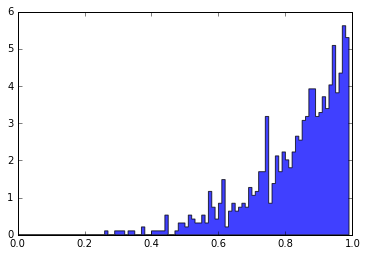

In [175]:
plt.figure()

a0, b0 = 5, 1
beta_samples = np.random.beta(a0, b0, 1000)

n, bins, patches = plt.hist(beta_samples,[x*10**(-2) for x in range(100)], normed=1, histtype='stepfilled')
plt.setp(patches, 'facecolor', 'b', 'alpha', 0.75)

plt.xlim([0,1])
plt.show()

Now let's re-implement the MP sampling function, accounting for the prior information...

In [176]:
### SAMPLE MONDRIAN PROCESS WITH PRIOR INFORMATION ###
def draw_informed_Mondrian(theta_space, table, budget=5):
    
    # INFORMATIVE PRIORS
    upper_cut = (5., 1.)
    lower_cut = (1., 5.)
    middle_cut = (5., 5.)
    neutral_cut = (1., 1.)
    priors_dict = { '-1':lower_cut, '0':neutral_cut, '1':upper_cut, 
                   '-1 0':lower_cut, '-1 1':middle_cut, '0 1':upper_cut,
                   '-1 0 1': middle_cut
                  }
    
    headers = list(table)
    cut_history = []
    
    return draw_informed_Mondrian_at_t(theta_space, table, 0, budget, priors_dict, headers, cut_history)
    
    
def draw_informed_Mondrian_at_t(theta_space, table, t, budget, priors_dict, headers, cut_history):
    # calc linear dimension
    dists = theta_space[:,1] - theta_space[:,0]
    lin_dim = np.sum(dists)
    
    # draw clock value
    T = np.random.exponential(scale=1./lin_dim)
    
    ### FOR NOW, CUT ALL DIMS AND THEN STOP
    # check if clock has rung
    #if t+T > budget: 
    #    return (theta_space, None, None)
    
    # get dimensions cut so far
    dim_mask = [1.] * len(headers)
    for idx, h in enumerate(headers):
        for c in cut_history:
            if h in c: 
                dim_mask[idx] = 0.
                break
                
    # if all dimensions have been cut, return
    if np.sum(dim_mask) == 0.: return (theta_space, None, None)
    dim_mask = np.array(dim_mask)
    
    # draw dimension to cut
    dim_probs = ((dists/lin_dim) * dim_mask) 
    dim_probs /= np.sum(dim_probs)
    d = np.argmax(np.random.multinomial(n=1, pvals=dim_probs))
    
    # look-up prior information
    if len(cut_history) == 0:
        # no need to look for matches, just check dimension
        matching_prior_info = np.unique(table[headers[d]])
    
    else:
        #query = ' & '.join(cut_history) # without nulls 
        query = ' & '.join( [ '( '+c.split('==')[0]+' == 0 | '+c+' )' for c in cut_history] ) # including nulls
    
        matching_prior_info = np.unique(table.query(query)[headers[d]]).tolist()
    
    prior_type_str = ' '.join([str(int(x)) for x in matching_prior_info])
    prior_params = priors_dict[prior_type_str]
    
    # make scaled cut
    x = (theta_space[d,1] - theta_space[d,0]) * np.random.beta(prior_params[0], prior_params[1])
    
    # make lower partition
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x 
    M_left = draw_informed_Mondrian_at_t(theta_left, table, t+T, budget, priors_dict, headers, cut_history+[headers[d]+' == -1.'])
    
    # make upper partition
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_informed_Mondrian_at_t(theta_right, table, t+T, budget, priors_dict, headers, cut_history+[headers[d]+' == 1.'])
    
    return (theta_space, M_left, M_right)

Let's sample from this prior...

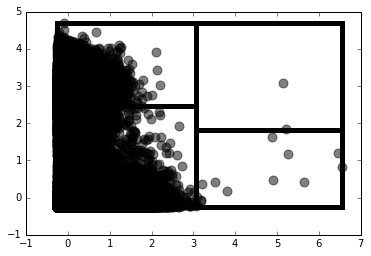

In [188]:
sample = draw_informed_Mondrian(np.array([[data[:,5].min(),data[:,5].max()],[data[:,6].min(),data[:,6].max()]]), table[['CD4', 'CD8']], budget=2.)

plt.scatter(data[:,5], data[:,6], c='k', edgecolors='k', s=80, alpha=.5)
print_partitions(sample)

plt.show()

## Experiment #1: 2D Simulation

Let's now test out the idea on a 2D subset of the data: the *CD4* and *CD8* features.

In [214]:
data_2d = np.hstack([data[:,5][np.newaxis].T, data[:,6][np.newaxis].T])
np.random.shuffle(data_2d)
data_2d = data_2d[:1000,:]
print data_2d.shape

x_min, y_min, x_max, y_max = data_2d[:,0].min(), data_2d[:,1].min(), data_2d[:,0].max(), data_2d[:,1].max()

(1000, 2)


##### Inference with Accept-Reject Algorithm

We will obtain the posterior distribution over partitions via accept-reject sampling.  First, we need to obtain an approx. MLE to use in the denominator... 

In [219]:
# run K medians
medians, assignments = get_K_medians(data_2d, K=4, lambda_k=.0000001, max_iterations=500)

# get bounds for each cluster
bounds = []
for k_idx in np.unique(assignments):
    idxs = np.nonzero(assignments==k_idx)[0]
    bounds.append( [(data_2d[idxs,0].min(), data_2d[idxs,0].max()), (data_2d[idxs,1].min(), data_2d[idxs,1].max())] )

#Calculate max. likelihood estimate
log_p_MLE = 0.
for k_idx in np.unique(assignments):
    k_count = len(np.nonzero(assignments==k_idx)[0])
    log_p_MLE += k_count * (-np.log(bounds[k_idx][0][1]-bounds[k_idx][0][0]) + -np.log(bounds[k_idx][1][1]-bounds[k_idx][1][0]))
    
print "log prob. MLE: %f" %(log_p_MLE)

log prob. MLE: -145.665145


Now run accept-reject to collect posterior samples...

In [222]:
def get_Mondrian_partition_bounds(p):
    if not p[1] and not p[2]: 
        return [[(p[0][0,0], p[0][0,1]), (p[0][1,0], p[0][1,1])]]
    else:
        return get_Mondrian_partition_bounds(p[1]) + get_Mondrian_partition_bounds(p[2])

mcmc_its = 100000
N = data_2d.shape[0]

samples = []
rejects = []
for idx in xrange(mcmc_its):
    
    sample = draw_informed_Mondrian(np.array([[x_min, x_max], [y_min, y_max]]), table[['CD4', 'CD8']], budget=2.)
    sample_bounds = get_Mondrian_partition_bounds(sample)
    
    log_p_sample = 0.
    for n in xrange(N):
        for k in xrange(len(sample_bounds)):
            if data_2d[n,0] > sample_bounds[k][0][0] and data_2d[n,0] < sample_bounds[k][0][1] \
            and data_2d[n,1] > sample_bounds[k][1][0] and data_2d[n,1] < sample_bounds[k][1][1]:
                log_p_sample += -np.log(sample_bounds[k][0][1]-sample_bounds[k][0][0]) + -np.log(sample_bounds[k][1][1]-sample_bounds[k][1][0])
                break
    
    # perform accept-reject step
    log_p_ratio = log_p_sample - log_p_MLE
    if log_p_ratio >= np.log(np.random.uniform(low=0, high=1.)):
        samples.append(sample)
    else:
        rejects.append(sample)
        
    if (idx+1) % 1000 == 0:
        print "Iteration %d, Samples %d" %(idx+1, len(samples))
        
print "Number of samples collected: %d" %(len(samples))

Iteration 1000, Samples 0
Iteration 2000, Samples 1
Iteration 3000, Samples 2
Iteration 4000, Samples 3
Iteration 5000, Samples 4
Iteration 6000, Samples 4
Iteration 7000, Samples 4
Iteration 8000, Samples 5
Iteration 9000, Samples 5
Iteration 10000, Samples 6
Iteration 11000, Samples 8
Iteration 12000, Samples 9
Iteration 13000, Samples 10
Iteration 14000, Samples 10
Iteration 15000, Samples 11
Iteration 16000, Samples 12
Iteration 17000, Samples 12
Iteration 18000, Samples 15
Iteration 19000, Samples 16
Iteration 20000, Samples 16
Iteration 21000, Samples 16
Iteration 22000, Samples 17
Iteration 23000, Samples 18
Iteration 24000, Samples 18
Iteration 25000, Samples 18
Iteration 26000, Samples 19
Iteration 27000, Samples 20
Iteration 28000, Samples 21
Iteration 29000, Samples 21
Iteration 30000, Samples 21
Iteration 31000, Samples 22
Iteration 32000, Samples 22
Iteration 33000, Samples 22
Iteration 34000, Samples 22
Iteration 35000, Samples 22
Iteration 36000, Samples 24
Iteration 370

Now let's visualize the posterior samples...

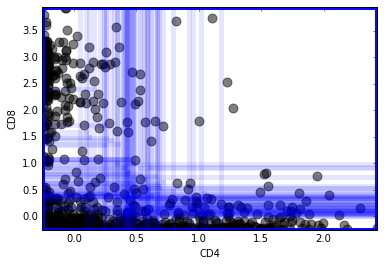

In [233]:
#### plt.figure()

print_posterior(data_2d, samples, trans_level=.05, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("")
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()